# Identifying neighbourhood orientation: rotationally symmetric structures

*Background:*
Rotationally equivariant geometric GNNs aggregate local geometric information via summing together the neighbourhood geometric features, which are either **cartesian vectors** or **higher order spherical tensors**. 
The ideal geometric GNN would injectively aggregate local geometric infromation to perfectly identify neighbourhood identities, orientations, etc.
In practice, the choice of basis (cartesian vs. spherical) comes with tradeoffs between tractability and empirical performance.

*Experiment:*
In this notebook, we study how rotational symmetries interact with tensor order in equivariant GNNs. 
We evaluate equivariant layers on their ability to distinguish the orientation of **structures with rotational symmetry**. 
An [$L$-fold symmetric structure](https://en.wikipedia.org/wiki/Rotational_symmetry) does not change when rotated by an angle $\frac{2\pi}{L}$ around a point (in 2D) or axis (3D).
We consider two *distinct* rotated versions of each $L$-fold symmetric structure and train single layer equivariant GNNs to classify the two orientations using the updated geometric features.

![Rotationally symmetric structures](fig/rotsym.png)

*Result:*
- **We find that layers using order $L$ tensors are unable to identify the orientation of structures with rotation symmetry higher than $L$-fold.** This observation may be attributed to **spherical harmonics**, which serve as an orthonormal basis for spherical tensor features and exhibit rotational symmetry themselves.
- Layers such as E-GNN and GVP-GNN using **cartesian vectors** (corresponding to tensor order 1) are popular as working with higher order tensors can be computationally intractable for many applications. However, E-GNN and GVP-GNN are particularly poor at disciminating orientation of rotationally symmetric structures. 

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import random
import math
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_undirected
import e3nn
from functools import partial

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))
print("e3nn version {}".format(e3nn.__version__))

from experiments.utils.plot_utils import plot_2d
from experiments.utils.train_utils import run_experiment
from models import SchNetModel, DimeNetPPModel, SphereNetModel, EGNNModel, GVPGNNModel, TFNModel, MACEModel

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version 1.12.1+cu113
PyG version 2.3.1
e3nn version 0.5.1
Using device: cuda


In [3]:
def create_rotsym_envs(fold=3):
    dataset = []

    # Environment 0
    atoms = torch.LongTensor([ 0 ] + [ 0 ] * fold)
    # edges read vertically; star graph: 0 -> 1, 0 -> 2 ...
    edge_index = torch.LongTensor( [ [0] * fold, [i for i in range(1, fold+1)] ] )
    x = torch.Tensor([1,0,0])
    # position of the star graph
    pos = [
        torch.Tensor([0,0,0]),  # origin
        x,   # first spoke 
    ]
    for count in range(1, fold):
        R = e3nn.o3.matrix_z(torch.Tensor([2*math.pi/fold * count])).squeeze(0)
        pos.append(x @ R.T)
    pos = torch.stack(pos)
    y = torch.LongTensor([0])  # Label 0
    data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data1.edge_index = to_undirected(data1.edge_index)
    dataset.append(data1)
    
    # Environment 1
    q = 2*math.pi/(fold + random.randint(1, fold))
    assert q < 2*math.pi/fold
    Q = e3nn.o3.matrix_z(torch.Tensor([q])).squeeze(0)
    pos = pos @ Q.T
    y = torch.LongTensor([1])  # Label 1
    data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data2.edge_index = to_undirected(data2.edge_index)
    dataset.append(data2)
    
    return dataset

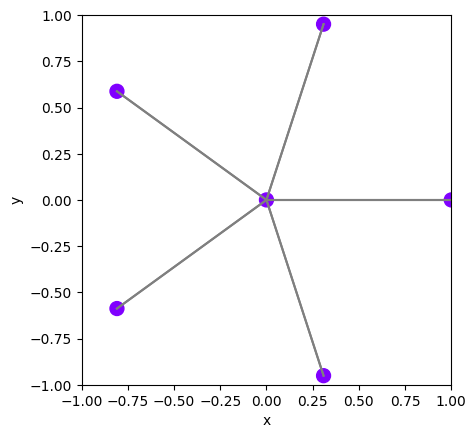

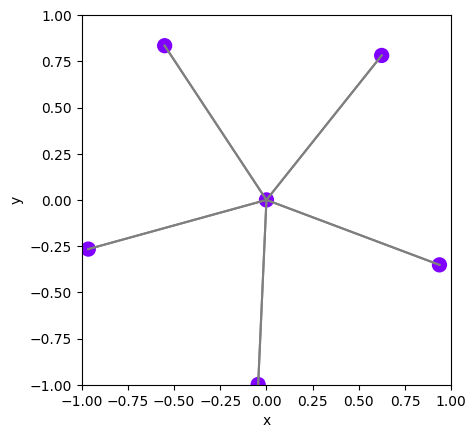

In [4]:
fold = 5

# Create dataset
dataset = create_rotsym_envs(fold)
for data in dataset:
    plot_2d(data, lim=1)

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [5]:
# Set parameters
model_name = "tfn"
correlation = 2
max_ell = 5

model = {
    "schnet": SchNetModel,
    "dimenet": DimeNetPPModel,
    "spherenet": SphereNetModel,
    "egnn": partial(EGNNModel, equivariant_pred=True),
    "gvp": partial(GVPGNNModel, equivariant_pred=True),
    "tfn": partial(TFNModel, max_ell=max_ell, equivariant_pred=True),
    "mace": partial(MACEModel, max_ell=max_ell, correlation=correlation, equivariant_pred=True),
}[model_name](num_layers=1, in_dim=1, out_dim=2)

best_val_acc, test_acc, train_time = run_experiment(
    model, 
    dataloader,
    val_loader, 
    test_loader,
    n_epochs=100,
    n_times=10,
    device=device,
    verbose=False
)

Running experiment for TFNModel (cuda).


  0%|          | 0/10 [00:00<?, ?it/s]

/home/pai/lib/python3.9/site-packages/e3nn/o3/_spherical_harmonics.py:92: UserWarning: FALLBACK path has been taken inside: compileCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
To report the issue, try enable logging via setting the envvariable ` export PYTORCH_JIT_LOG_LEVEL=manager.cpp`
 (Triggered internally at  ../torch/csrc/jit/codegen/cuda/manager.cpp:237.)
  sh = _spherical_harmonics(self._lmax, x[..., 0], x[..., 1], x[..., 2])



Done! Averaged over 10 runs: 
 - Training time: 2.84s ± 1.64. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 

